In [1]:
! pip install numpy pandas plotly scipy matplotlib scikit-learn

In [2]:
import numpy as np
import os
import pandas as pd
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import tarfile
import zipfile
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
from scipy.io import loadmat
import glob
import random
import matplotlib.image as img
from PIL import Image
from sklearn.decomposition import PCA

In [3]:
faces_image = 'data/faces/rawdata'
example = 0.2
Value = []
for numberFile in  os.listdir(faces_image):
    if random.random() <= example:
        value_bytes = open(os.path.join(faces_image, numberFile), "rb").read()
        imageFace = Image.frombytes('L', (128,128), value_bytes)
        Value.append(np.array(imageFace).flatten())
Value = np.array(Value)

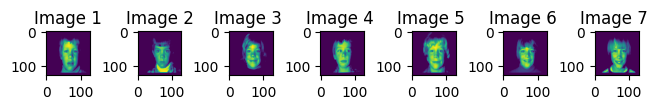

In [4]:
#Se realiza está función simplemente con el objetivo de ver las imagenes cargadas
def seven_images_homework(images, image_one, image_two, image_three, image_four, image_five, image_six, image_seven):
    figure_size = lambda X: X.reshape(128,128)
    figure, ax = plt.subplots(1,7, constrained_layout=True)
    ax[0].imshow(figure_size(images[image_one]))
    ax[0].set_title(label="Image %s"% image_one)
    ax[1].imshow(figure_size(images[image_two]))
    ax[1].set_title(label="Image %s"% image_two)
    ax[2].imshow(figure_size(images[image_three]))
    ax[2].set_title(label="Image %s "% image_three)
    ax[3].imshow(figure_size(images[image_four]))
    ax[3].set_title(label="Image %s "% image_four)
    ax[4].imshow(figure_size(images[image_five]))
    ax[4].set_title(label="Image %s "% image_five)
    ax[5].imshow(figure_size(images[image_six]))
    ax[5].set_title(label="Image %s "% image_six)
    ax[6].imshow(figure_size(images[image_seven]))
    ax[6].set_title(label="Image %s "% image_seven)
    plt.show()

seven_images_homework(Value, 1, 2, 3, 4, 5, 6, 7)

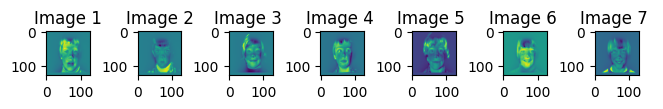

In [5]:
#Se obtienes las mean_faces
Value_mean = Value.mean(axis=0)
Value_center = Value - Value_mean
seven_images_homework(Value_center, 1, 2, 3, 4, 5, 6, 7)

In [6]:
pca_five_components = PCA(n_components=5)
Value_reduced_pca = pca_five_components.fit_transform(Value_center)

In [7]:
class KMeansCustom:
    def __init__(self, n_clusters, max_iters=200, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None

    def fit(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        # Inicialización de centroides de forma aleatoria
        self.centroids = self.initialize_centroids(X)
        for _ in range(self.max_iters):
            # Asignar puntos a los centroides más cercanos
            clusters = self.assign_clusters(X)
            # Calcular nuevos centroides
            new_centroids = self.calculate_centroids(X, clusters)
            # Comprobar convergencia
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        # Asignar puntos a los centroides más cercanos y devolver las asignaciones
        return self.assign_clusters(X)
        
    def initialize_centroids(self, X):
        # Inicialización KMeans
        centroids = [X[np.random.choice(len(X))]]
        for _ in range(1, self.n_clusters):
            distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
            prob = distances / distances.sum()
            cumulative_prob = prob.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumulative_prob):
                if r < p:
                    centroids.append(X[j])
                    break
        return centroids 

    def assign_clusters(self, X):
        # Asignar puntos al clúster más cercano
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        return clusters

    def calculate_centroids(self, X, clusters):
        # Calcular nuevos centroides
        new_centroids = [X[clusters == cluster].mean(axis=0) for cluster in range(self.n_clusters)]
        return np.array(new_centroids)

In [8]:
#Aplicamos el KMeans para 7 clusters
kmeans = KMeansCustom(7)
kmeans.fit(Value_reduced_pca)
labels = kmeans.predict(Value_reduced_pca)

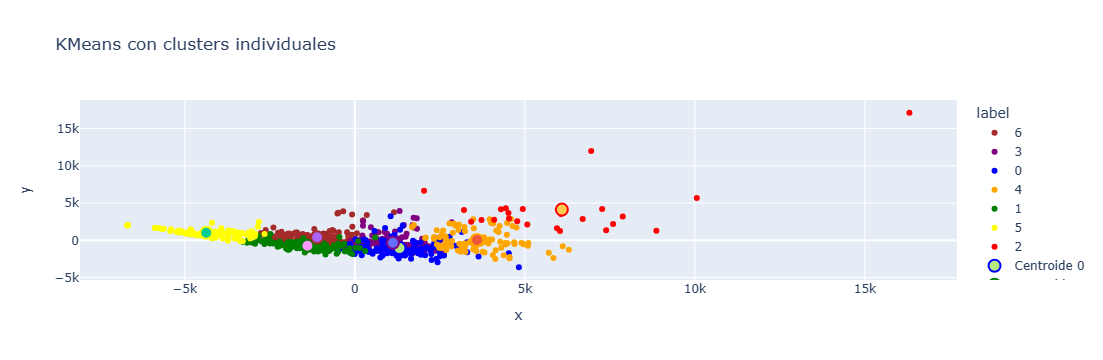

In [65]:
dataframe_labels_images = pd.DataFrame({'x': Value_reduced_pca[:, 0], 'y': Value_reduced_pca[:, 1], 'label': labels})
#Se obtienes los centroides
centroids_kmeans = kmeans.centroids
size_centroids = len(centroids_kmeans)
centroids_dataframe_labels_images = pd.DataFrame({'x': centroids_kmeans[:, 0], 'y': centroids_kmeans[:, 1], 'label': [f'Centroide {i}' for i in range(size_centroids)],
                             'cluster': range(size_centroids)})
#Se unen labels con centroides
combined_combined_dataframe_labels_images = pd.concat([dataframe_labels_images, centroids_dataframe_labels_images])

colors_labels = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown']

graphic_kmeans = px.scatter(combined_combined_dataframe_labels_images, x='x', y='y', color='label', color_discrete_map={i: c for i, c in enumerate(colors_labels)},
                 title='KMeans con clusters individuales')
# Personalizar los marcadores de los centroides
for cluster_individual in centroids_dataframe_labels_images['cluster'].unique():
    graphic_kmeans.update_traces(marker=dict(size=12, symbol='circle', line=dict(width=2, color=colors_labels[cluster_individual])),
                      selector=dict(name=f'Centroide {cluster_individual}'))

graphic_kmeans.show()

In [66]:
# Crear un diccionario para guardar las imagenes con la finalidad de poder obtner la imagen por medio de las coordenadas
cluster_to_indices = {}

for i, label in enumerate(labels):
    if label not in cluster_to_indices:
        cluster_to_indices[label] = []
    cluster_to_indices[label].append(i)
# cluster_to_indices contiene ahora las listas de índices de imágenes para cada etiqueta de clúster

In [80]:
#Se realiza una función para obtener las imagenes con respecto a la distancia eucladiana al centroide, en orden descendente.
def imagen_coordenadas(centroid_value):
    indices_of_images_in_cluster = cluster_to_indices[centroid_value]
    distances_and_indices_array = []
    # Calcular las distancias y guardarlas junto con los índices
    for i in indices_of_images_in_cluster:
        coordinates = Value_reduced_pca[i]
        distance = np.linalg.norm(coordinates - centroid_value)
        distances_and_indices_array.append((i, distance))
    # Ordenar la lista de distancias y índices por distancia
    distances_and_indices_array.sort(key=lambda x: x[1])
    for i, distance in distances_and_indices_array:
        print(f"Distancia de la imagen {i} al centroide {centroid_value}: {distance}")

In [81]:
#Se crea método para ver las 4 imagenes más cercanas
def plot_4_images(data,ix_1, ix_2 , ix_3, i_4):
    fn_shape = lambda X: X.reshape(128,128)
    fig, ax = plt.subplots(1,4, constrained_layout=True)
    ax[0].imshow(fn_shape(data[ix_1]))
    ax[0].set_title(label="Image %s"% ix_1)
    ax[1].imshow(fn_shape(data[ix_2]))
    ax[1].set_title(label="Image %s"% ix_2)
    ax[2].imshow(fn_shape(data[ix_3]))
    ax[2].set_title(label="Image %s "% ix_3)
    ax[3].imshow(fn_shape(data[i_4]))
    ax[3].set_title(label="Image %s "% i_4)
    plt.show()

Distancia de la imagen 463 al centroide 0: 1059.726092220827
Distancia de la imagen 120 al centroide 0: 1096.354598551825
Distancia de la imagen 126 al centroide 0: 1235.43991798304
Distancia de la imagen 460 al centroide 0: 1285.0230362877164
Distancia de la imagen 222 al centroide 0: 1390.4138773838467
Distancia de la imagen 305 al centroide 0: 1410.9736225543184
Distancia de la imagen 469 al centroide 0: 1417.3740336345406
Distancia de la imagen 465 al centroide 0: 1435.6599178154577
Distancia de la imagen 398 al centroide 0: 1455.4490604481557
Distancia de la imagen 699 al centroide 0: 1514.557560248678
Distancia de la imagen 258 al centroide 0: 1532.151864284221
Distancia de la imagen 38 al centroide 0: 1567.6517569630382
Distancia de la imagen 728 al centroide 0: 1646.578723982474
Distancia de la imagen 236 al centroide 0: 1655.764789474142
Distancia de la imagen 142 al centroide 0: 1686.0848603982836
Distancia de la imagen 774 al centroide 0: 1687.6038829464642
Distancia de la i

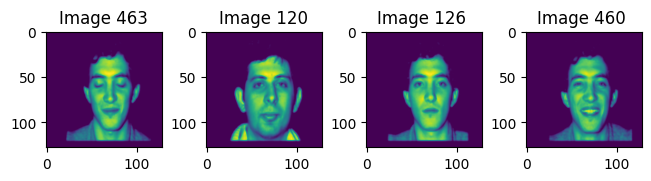

In [82]:
#Se obtiene imagenes más cercanas al centroide 0
imagen_coordenadas(0)
plot_4_images(Value, 463, 120, 126, 460)

Distancia de la imagen 127 al centroide 1: 880.2107551482653
Distancia de la imagen 250 al centroide 1: 966.9284619542161
Distancia de la imagen 191 al centroide 1: 1120.2509267062078
Distancia de la imagen 399 al centroide 1: 1152.630353460283
Distancia de la imagen 692 al centroide 1: 1289.6351815438456
Distancia de la imagen 150 al centroide 1: 1291.4112683070368
Distancia de la imagen 423 al centroide 1: 1406.3739433651756
Distancia de la imagen 676 al centroide 1: 1430.8791356341442
Distancia de la imagen 34 al centroide 1: 1473.6972950341224
Distancia de la imagen 223 al centroide 1: 1559.9081608652007
Distancia de la imagen 71 al centroide 1: 1563.5081825757604
Distancia de la imagen 767 al centroide 1: 1608.3155709381256
Distancia de la imagen 505 al centroide 1: 1636.765959829718
Distancia de la imagen 506 al centroide 1: 1664.6028157154774
Distancia de la imagen 712 al centroide 1: 1666.0520522456768
Distancia de la imagen 697 al centroide 1: 1669.5381909673756
Distancia de l

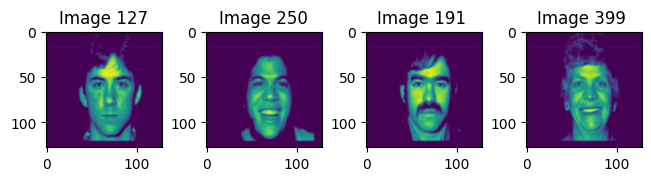

In [83]:
#Se obtiene imagenes más cercanas al centroide 1
imagen_coordenadas(1)
plot_4_images(Value, 127, 250, 191, 399)

Distancia de la imagen 648 al centroide 2: 5597.822217394477
Distancia de la imagen 758 al centroide 2: 5716.905540536421
Distancia de la imagen 759 al centroide 2: 5746.4929761321
Distancia de la imagen 604 al centroide 2: 5941.892657921339
Distancia de la imagen 655 al centroide 2: 6106.921817532724
Distancia de la imagen 652 al centroide 2: 6264.600358501034
Distancia de la imagen 606 al centroide 2: 6285.764137738205
Distancia de la imagen 651 al centroide 2: 6408.238378666814
Distancia de la imagen 756 al centroide 2: 6483.756162644572
Distancia de la imagen 344 al centroide 2: 6573.839035159537
Distancia de la imagen 607 al centroide 2: 6701.258795576695
Distancia de la imagen 404 al centroide 2: 6778.129226388328
Distancia de la imagen 760 al centroide 2: 7400.872062178245
Distancia de la imagen 414 al centroide 2: 7879.349836065536
Distancia de la imagen 677 al centroide 2: 8528.534295753538
Distancia de la imagen 409 al centroide 2: 8574.749839690912
Distancia de la imagen 645

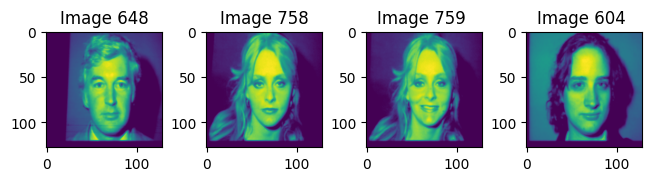

In [84]:
#Se obtiene imagenes más cercanas al centroide 2
imagen_coordenadas(2)
plot_4_images(Value, 648, 758, 759, 604)

Distancia de la imagen 281 al centroide 3: 932.2263808236346
Distancia de la imagen 3 al centroide 3: 1014.9572864188975
Distancia de la imagen 37 al centroide 3: 1203.610432547353
Distancia de la imagen 301 al centroide 3: 1204.4259676403856
Distancia de la imagen 761 al centroide 3: 1218.0105205020946
Distancia de la imagen 203 al centroide 3: 1237.0184702886381
Distancia de la imagen 335 al centroide 3: 1243.4580723187323
Distancia de la imagen 475 al centroide 3: 1275.0790286317983
Distancia de la imagen 729 al centroide 3: 1301.8777906605537
Distancia de la imagen 694 al centroide 3: 1345.4177614857065
Distancia de la imagen 705 al centroide 3: 1351.5196511057525
Distancia de la imagen 290 al centroide 3: 1375.7142574343984
Distancia de la imagen 751 al centroide 3: 1380.5833263361558
Distancia de la imagen 474 al centroide 3: 1380.7264394298943
Distancia de la imagen 476 al centroide 3: 1434.489103876177
Distancia de la imagen 695 al centroide 3: 1451.8073665681454
Distancia de l

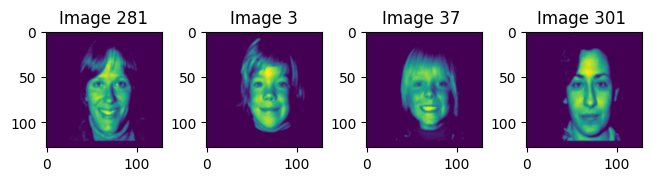

In [85]:
#Se obtiene imagenes más cercanas al centroide 3
imagen_coordenadas(3)
plot_4_images(Value, 281, 3, 37, 301)

Distancia de la imagen 268 al centroide 4: 2378.8409869031066
Distancia de la imagen 44 al centroide 4: 2656.895082740081
Distancia de la imagen 49 al centroide 4: 2743.7309881374836
Distancia de la imagen 660 al centroide 4: 2805.650960640357
Distancia de la imagen 641 al centroide 4: 2808.697445844395
Distancia de la imagen 362 al centroide 4: 2867.3673342177253
Distancia de la imagen 24 al centroide 4: 2893.2902747559024
Distancia de la imagen 121 al centroide 4: 2949.9573765629766
Distancia de la imagen 188 al centroide 4: 3016.179009789316
Distancia de la imagen 640 al centroide 4: 3029.292797270436
Distancia de la imagen 47 al centroide 4: 3037.8341212078158
Distancia de la imagen 332 al centroide 4: 3050.797635976048
Distancia de la imagen 484 al centroide 4: 3081.1624901229534
Distancia de la imagen 144 al centroide 4: 3156.75297078791
Distancia de la imagen 5 al centroide 4: 3306.3269059899485
Distancia de la imagen 727 al centroide 4: 3313.0325623768813
Distancia de la imagen

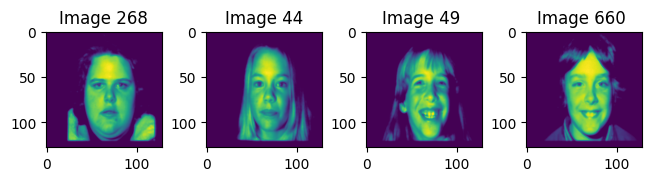

In [86]:
#Se obtiene imagenes más cercanas al centroide 4
imagen_coordenadas(4)
plot_4_images(Value, 268, 44, 49, 660)

Distancia de la imagen 443 al centroide 5: 3063.96871296564
Distancia de la imagen 711 al centroide 5: 3073.66671138142
Distancia de la imagen 771 al centroide 5: 3137.5266126731103
Distancia de la imagen 292 al centroide 5: 3276.481665529525
Distancia de la imagen 489 al centroide 5: 3284.1092216379025
Distancia de la imagen 62 al centroide 5: 3308.326319990594
Distancia de la imagen 235 al centroide 5: 3332.7534433958735
Distancia de la imagen 441 al centroide 5: 3342.0142863182264
Distancia de la imagen 772 al centroide 5: 3349.722301340398
Distancia de la imagen 436 al centroide 5: 3388.1369012534824
Distancia de la imagen 710 al centroide 5: 3444.2503932937802
Distancia de la imagen 275 al centroide 5: 3460.116303358153
Distancia de la imagen 158 al centroide 5: 3487.2775735191844
Distancia de la imagen 448 al centroide 5: 3547.8001200730832
Distancia de la imagen 440 al centroide 5: 3567.95999514972
Distancia de la imagen 277 al centroide 5: 3581.4834870934774
Distancia de la ima

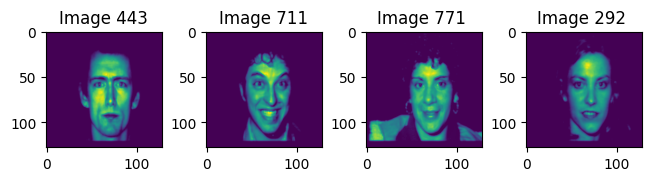

In [87]:
#Se obtiene imagenes más cercanas al centroide 5
imagen_coordenadas(5)
plot_4_images(Value, 443, 711, 771, 292)

Distancia de la imagen 27 al centroide 6: 530.6955014223437
Distancia de la imagen 186 al centroide 6: 602.7096129980697
Distancia de la imagen 114 al centroide 6: 737.1002592492234
Distancia de la imagen 395 al centroide 6: 796.5222162044048
Distancia de la imagen 39 al centroide 6: 824.9564202081136
Distancia de la imagen 766 al centroide 6: 832.2948925341572
Distancia de la imagen 672 al centroide 6: 867.010656548986
Distancia de la imagen 702 al centroide 6: 1031.5462416409268
Distancia de la imagen 366 al centroide 6: 1034.4099631692538
Distancia de la imagen 775 al centroide 6: 1117.219246078925
Distancia de la imagen 97 al centroide 6: 1122.1857066897949
Distancia de la imagen 764 al centroide 6: 1123.8784424070711
Distancia de la imagen 708 al centroide 6: 1151.65727270333
Distancia de la imagen 380 al centroide 6: 1163.4296856779854
Distancia de la imagen 472 al centroide 6: 1174.6237070823072
Distancia de la imagen 312 al centroide 6: 1187.1298866713214
Distancia de la imagen

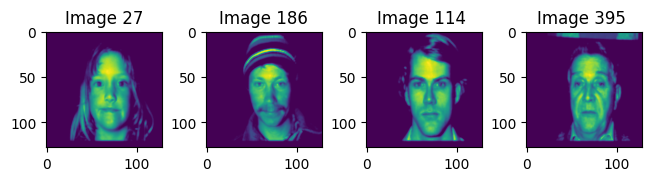

In [88]:
#Se obtiene imagenes más cercanas al centroide 6
imagen_coordenadas(6)
plot_4_images(Value, 27, 186, 114, 395)